In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from eda import *
from processing import *
from sklearn.pipeline import Pipeline
import joblib
# Uncomment for first use
# nltk.download('punkt')
# nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
sns.set_style("whitegrid")

c:\Users\jakub\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\jakub\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df=pd.read_csv('../data/train.csv')

# Basic Data Overview

In this project we are using Disaster Tweets dataset from Kaggle to determine whether a given tweet informs about a real disaster or is a fake info. 

We have 5 columns:
* **id** : unique tweet id
* **keword** : extracted keyword from a given tweet
* **location** : location from which tweet was sent
* **text** : text of a tweet
* **target** : 0-1 value indicating whether a tweet is fake(0) or real (1)

In [3]:
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
df.shape

(7613, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df['keyword'].nunique()

221

In [7]:
df['location'].nunique()

3341

**First observations**
* We have 5 columns and 7613 rows
* We have some missing values in location and keyword column
* We have 221 unique keywords and more than 3000 unique locations
* Locations for the same place are written in different format in some rows

# EDA and Feature Engineering

**1. Target Analysis**

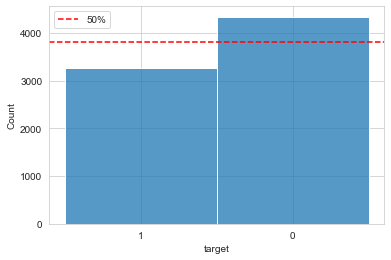

In [8]:
sns.histplot(df['target'].astype(str))
fifty_percent_count = len(df) / 2
plt.axhline(y=fifty_percent_count, color='red', linestyle='--', label='50%')
plt.legend()
plt.show()

In [9]:
target_percentage = df['target'].value_counts(normalize=True) * 100
percentage_table = pd.DataFrame({'Target': target_percentage.index, 'Percentage': target_percentage.values})
percentage_table

,Target,Percentage
0,0,57.034021
1,1,42.965979


There is a slight class imbalance - there are more false tweets

**2. Number of words in caps lock vs target**

In [10]:
pd.set_option('display.max_colwidth', None)

In [11]:
df['Caps_lock_word_count'] = df['text'].apply(count_caps_lock)
df[['text','Caps_lock_word_count']].head(10)

,text,Caps_lock_word_count
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,0
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0
3,"13,000 people receive #wildfires evacuation orders in California",0
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,0
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",0
7,I'm on top of the hill and I can see a fire in the woods...,1
8,There's an emergency evacuation happening now in the building across the street,0
9,I'm afraid that the tornado is coming to our area...,0


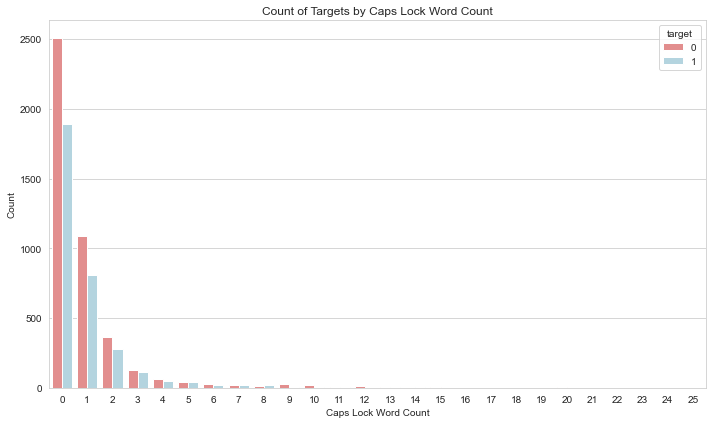

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Caps_lock_word_count', hue='target', palette=['lightcoral', 'lightblue'])
plt.xlabel('Caps Lock Word Count')
plt.ylabel('Count')
plt.title('Count of Targets by Caps Lock Word Count')
plt.tight_layout()
plt.show()

We can see that the majority of tweets don't have many words in caps lock. However we can see that the percentage of true tweets increases with the increase of caps lock words - more than 4 caps lock words have 50/50 false and true tweets

**3. Number of '!' vs target**

In [13]:
df['Number_of_exclamation'] = df['text'].apply(count_exclamation_mark)
df.head(10)

,id,keyword,location,text,target,Caps_lock_word_count,Number_of_exclamation
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,0
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,0,0
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,0,0
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1,1,0
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1,0,0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1,0,0


<Axes: xlabel='Number_of_exclamation', ylabel='count'>

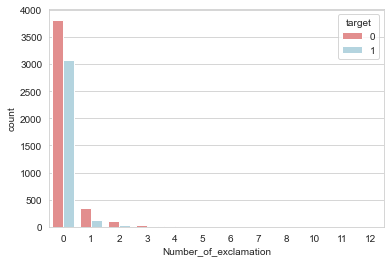

In [14]:
sns.countplot(df,x='Number_of_exclamation', hue='target',palette=['lightcoral', 'lightblue'])

In [15]:
pd.crosstab(df['Number_of_exclamation'], df['target'], normalize='index')*100

target,0,1
Number_of_exclamation,,
0,55.395997,44.604003
1,72.594142,27.405858
2,72.727273,27.272727
3,78.846154,21.153846
4,80.000000,20.000000
5,50.000000,50.000000
6,71.428571,28.571429
7,66.666667,33.333333
8,0.000000,100.000000


There is no obvious pattern, most tweets have 0,1,2 exclamation marks

In most groups there are more fake tweets

**4. Number of # vs target**

In [16]:
df['Number_of_hashtags']= df['text'].apply(count_hashtags)

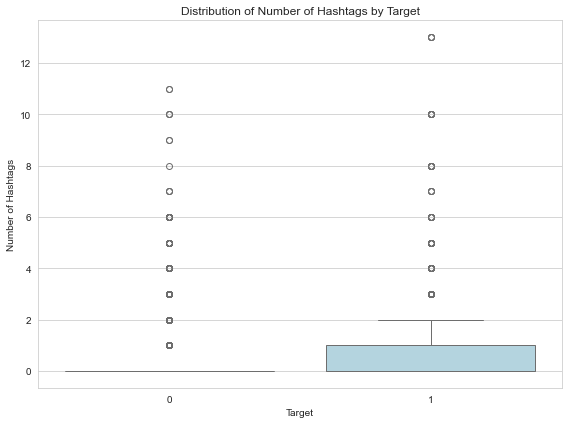

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='target', y='Number_of_hashtags', hue='target', palette=['lightcoral', 'lightblue'], dodge=False)
plt.legend().remove()
plt.xlabel('Target')
plt.ylabel('Number of Hashtags')
plt.title('Distribution of Number of Hashtags by Target')
plt.tight_layout()
plt.show()

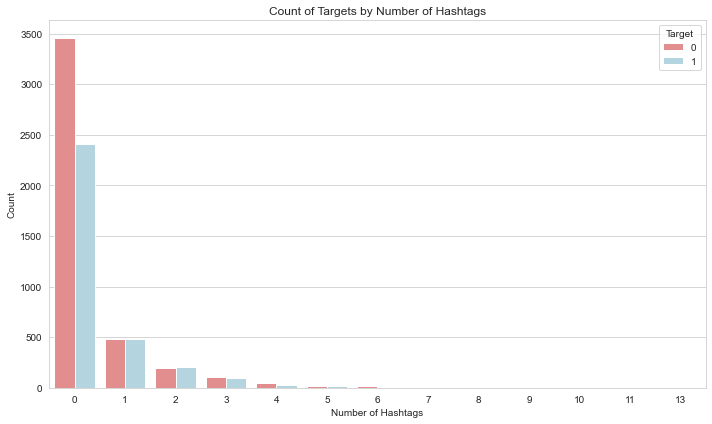

In [18]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Number_of_hashtags', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Number of Hashtags')
plt.xlabel('Number of Hashtags')
plt.ylabel('Count')
plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

The majority of tweets have 0 hashtags. For 1,2,3 hashtags there are circa 50/50 false and true tweets. If there is no hashtags the tweet is more likely to be false

**5. Number of words vs target**

In [19]:
df['Word_count'] = df['text'].apply(count_words)

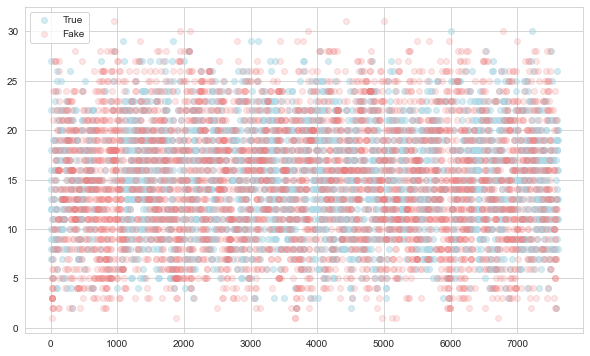

In [20]:
true = df[df['target']==1]
false = df[df['target']==0]

plt.figure(figsize=(10,6))
plt.scatter(true.index, true['Word_count'], label='True', color='lightblue',alpha=0.5)
plt.scatter(false.index, false['Word_count'], label='Fake', color='lightcoral',alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()

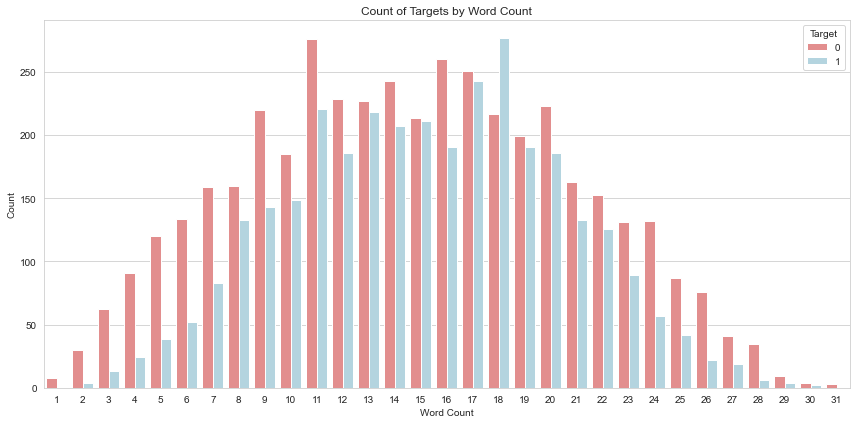

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Word_count', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Word Count')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.legend(title='Target', loc='upper right')
plt.tight_layout()
plt.show()

* there is no visible pattern between number of words and target
* We can only see that if the tweet is very short (1-10 words) or very long (>30 words) it is probably fake
* looks like normal distribution

**6. Punctuation vs target**

In [22]:
df['Punctuation_count'] = df['text'].apply(count_punctuation)

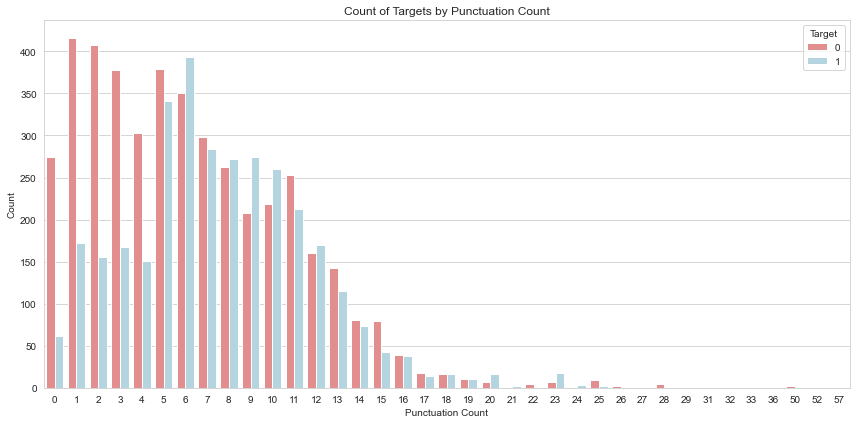

In [23]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Punctuation_count', hue='target', palette=['lightcoral', 'lightblue'])
plt.title('Count of Targets by Punctuation Count')
plt.xlabel('Punctuation Count')
plt.ylabel('Count')
plt.legend(title='Target')
plt.tight_layout()
plt.show()

* we can see a visible pattern : tweets with little punctuation tend to be fake, and tweets with 6-11 punctuation signs are more likely to be true

**7. Number of links vs target**

In [24]:
df['Link_count']=df['text'].apply(count_links)

<Axes: xlabel='Link_count', ylabel='count'>

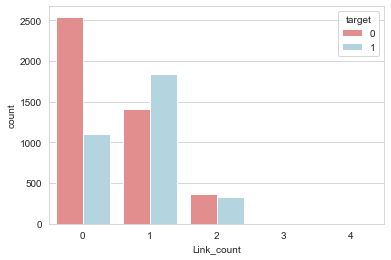

In [25]:
sns.countplot(df, x='Link_count', hue='target',palette=['lightcoral', 'lightblue'])

In [26]:
pd.crosstab(df['Link_count'], df['target'], normalize='index')*100

target,0,1
Link_count,,
0,69.824272,30.175728
1,43.517093,56.482907
2,52.932761,47.067239
3,59.090909,40.909091
4,100.000000,0.000000


**8. Number of stopwords vs target**

In [27]:
df['Stopword_count']=df['text'].apply(count_stopwords)

<Axes: xlabel='Stopword_count', ylabel='count'>

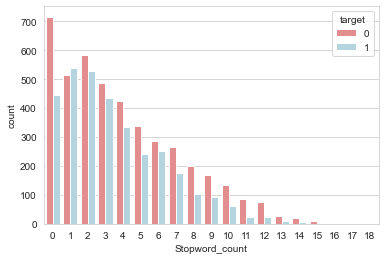

In [28]:
sns.countplot(df, x='Stopword_count', hue='target', palette=['lightcoral', 'lightblue'])

In [29]:
pd.crosstab(df['Stopword_count'],df['target'],normalize='index')*100

target,0,1
Stopword_count,,
0,61.724138,38.275862
1,48.812915,51.187085
2,52.565257,47.434743
3,52.819957,47.180043
4,56.126482,43.873518
5,58.304498,41.695502
6,53.445065,46.554935
7,60.407240,39.592760
8,65.901639,34.098361


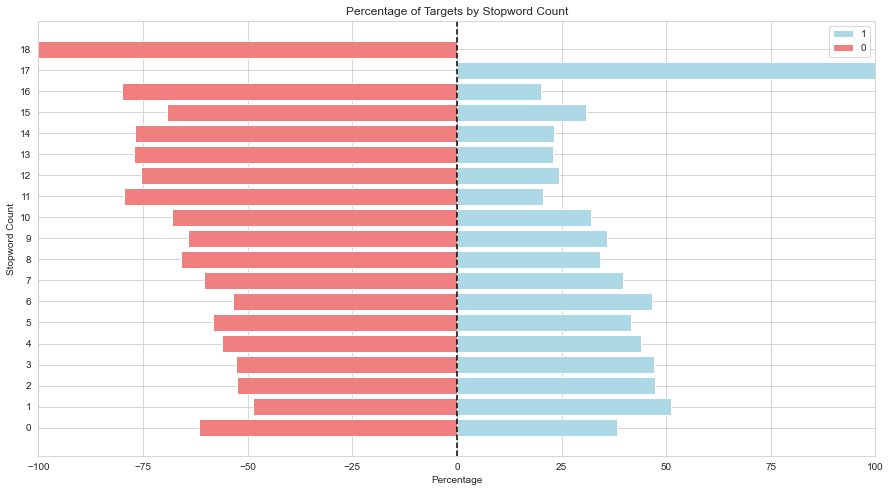

In [30]:
crosstab_normalized = pd.crosstab(df['Stopword_count'], df['target'], normalize='index') * 100

plt.figure(figsize=(15, 8))
legend_added = False
for index, row in crosstab_normalized.iterrows():
    plt.barh(
        str(index),
        row[1],
        color="lightblue",
        label="1" if not legend_added else "",
    )
    plt.barh(
        str(index),
        -row[0],
        color="lightcoral",
        label="0" if not legend_added else "",
    )
    if not legend_added:
        legend_added = True
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percentage")
plt.ylabel("Stopword Count")
plt.title("Percentage of Targets by Stopword Count")
plt.xlim(-100, 100)
plt.legend(loc="upper right")
plt.show()

* The percent of fake tweets is slightly higer when there are more stop words

**9. Number of mentions vs target**

In [31]:
df['Mentions_count']=df['text'].apply(count_mentions)

<Axes: xlabel='Mentions_count', ylabel='count'>

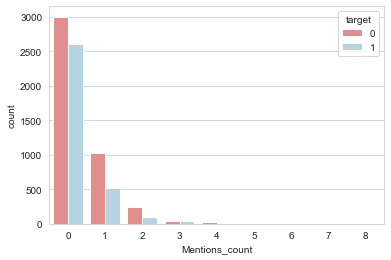

In [32]:
sns.countplot(df, x='Mentions_count', hue='target', palette=['lightcoral', 'lightblue'])

**10. Parts of speech vs target**

In [33]:
df['Verb_count'] = df['text'].apply(count_parts_of_speech, tag='V')
df['Noun_count'] = df['text'].apply(count_parts_of_speech, tag='N')
df['Adjective_count'] = df['text'].apply(count_parts_of_speech, tag='J')
df['Adverb_count'] = df['text'].apply(count_parts_of_speech, tag='R')

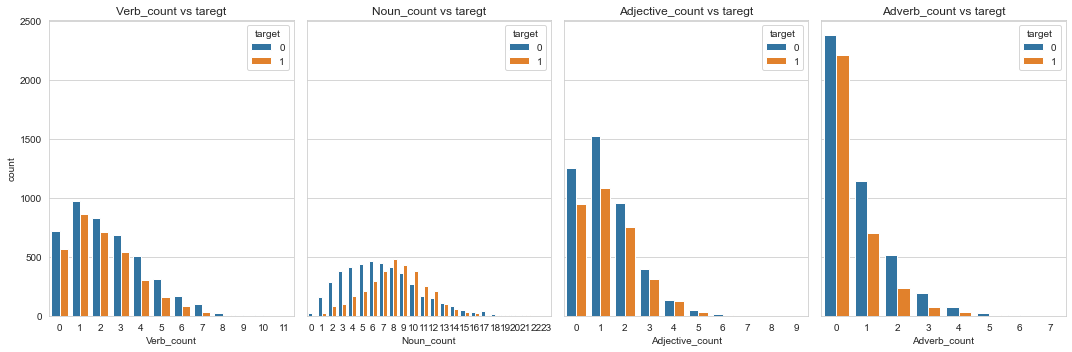

In [34]:
fig, axes = plt.subplots(1,4, figsize =(15,5), sharey=True)
parts = ['Verb_count', 'Noun_count', 'Adjective_count','Adverb_count']

for i,part in enumerate(parts):
    sns.countplot(data=df, x=part, hue='target', ax=axes[i])
    axes[i].set_title(f'{part} vs taregt')

plt.tight_layout()
plt.show()

* for verbs and adverbs there is a right-skewed count distribution for fake and true tweets
* We can see a visible pattern in Noun count : Fake tweets have less nouns that true ones

**Feature correlation**

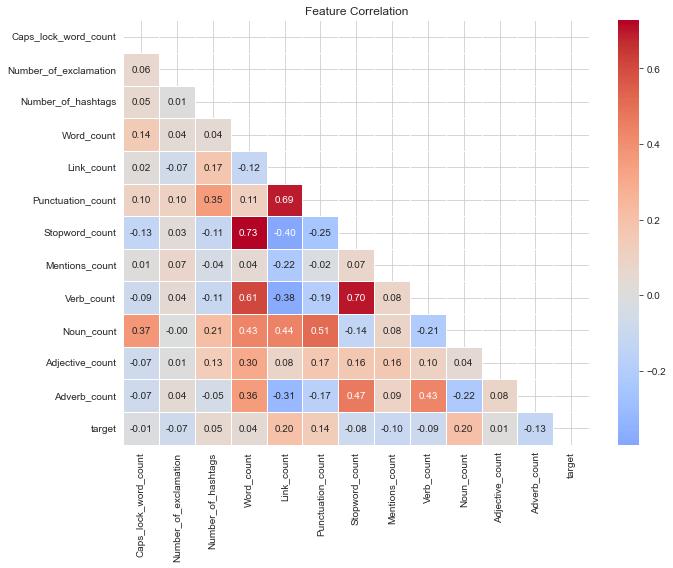

In [35]:
columns = ['Caps_lock_word_count', 'Number_of_exclamation', 'Number_of_hashtags', 
           'Word_count', 'Link_count', 'Punctuation_count', 'Stopword_count','Mentions_count','Verb_count','Noun_count','Adjective_count','Adverb_count', 'target']
correlation_matrix = df[columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, mask=mask, center=0)
plt.title('Feature Correlation')
plt.tight_layout()
plt.show()

We can see that new column like link_count, noun_count ,punctuation_count and adverb_count have the biggest correlation with the target

**Keywords vs target**

In [36]:
missing_keywords = len(df[df['keyword'].isna()])
missing_keywords

61

We have 61 missing keywords( maybe we will fill them in later)

In [37]:
only_missing_keywords = df[df['keyword'].isna()]
print("Percent of true emergencies where the keyword is missing:")
percent = len(only_missing_keywords[only_missing_keywords['target']==1])/missing_keywords
print((round(percent,2)*100), "%")

Percent of true emergencies where the keyword is missing:
69.0 %


The majority of tweets with missing keyword are about true disasters

In [38]:
top_keywords = df['keyword'].value_counts().head(20) # extracting top found keywords
top_keywords

keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: count, dtype: int64

In [39]:
print("{:<15} {:<15} {:<10} {:<10}".format('Keyword', 'Occurrences', 'True %', 'False %')) # analyse keword vs true or false tweet
print('\n')
for keyword,count in top_keywords.items():
    true = df[df['keyword']==keyword]['target'].mean()*100
    false = 100-true
    print("{:<15} {:<15} {:<10.2f} {:<10.2f}".format(keyword, count, true, false))


Keyword         Occurrences     True %     False %   


fatalities      45              57.78      42.22     
deluge          42              14.29      85.71     
armageddon      42              11.90      88.10     
sinking         41              19.51      80.49     
damage          41              46.34      53.66     
harm            41              9.76       90.24     
body%20bags     41              2.44       97.56     
outbreak        40              97.50      2.50      
evacuate        40              62.50      37.50     
fear            40              12.50      87.50     
collided        40              57.50      42.50     
siren           40              12.50      87.50     
twister         40              12.50      87.50     
windstorm       40              40.00      60.00     
sinkhole        39              69.23      30.77     
sunk            39              23.08      76.92     
hellfire        39              17.95      82.05     
weapon          39        

* We can see that words like: fatalities,outbreak, evacuate, sinkhole, famine are more likely to occure in true tweets whereas deluge, armageddon, sinking, harm, fear, siren ... are often used in fake tweets

**Location vs target**

In [40]:
print("Percent of tweets with missing location:", round(len(df[df['location'].isna()])*100/len(df),2),"%")

Percent of tweets with missing location: 33.27 %


In [41]:
top_locations = df['location'].value_counts().head(30) # let's extraxt top found locations
top_locations

location
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Australia            18
Chicago, IL          18
California           17
Everywhere           15
New York, NY         15
California, USA      15
Florida              14
San Francisco        14
United Kingdom       14
Los Angeles          13
Indonesia            13
Washington, D.C.     13
Toronto              12
NYC                  12
Ireland              12
Seattle              11
Earth                11
Name: count, dtype: int64

Locations are redundant : there are values like USA, United States, New York and New York,NY 

In [42]:
df['location'].nunique()

3341

In [43]:
# mapping values from the most frequent locations to their countries (pewnie jest jakis lepszy sposób na to )
df['Location_grouped'] = df['location'].apply(map_countries)  

In [44]:
top_locations_grouped = df['Location_grouped'].value_counts().head(10)
top_locations_grouped

Location_grouped
USA            372
UK              83
Canada          29
Nigeria         28
India           24
Mumbai          22
Kenya           20
Worldwide       19
Chicago, IL     18
Australia       18
Name: count, dtype: int64

* The majority of tweets is from USA

**Sentiment analysis**

Every sentence can have a different emotional background. Some tweets can be written in positive, happy, negavite, angry or scared way. In this part we will analyse positive and negative sentiment as well as subjectivity. Then we will move on to extracting more emotions like fear, anger, joy etc

In [45]:
df['polarity_score'] = df['text'].apply(get_polarity)
df['subjectivity_score'] = df['text'].apply(get_subjectivity)

Text(0.5, 1.0, 'Subjectivity vs target')

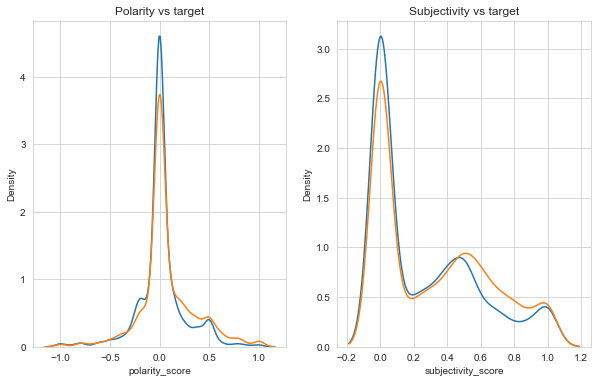

In [46]:
fig, axes = plt.subplots(1,2, figsize=(10,6))
true_tweets = df[df['target']==1]
false_tweets = df[df['target']==0]
sns.kdeplot(data=true_tweets['polarity_score'],  ax=axes[0])
sns.kdeplot(data=false_tweets['polarity_score'], ax=axes[0])
sns.kdeplot(data=true_tweets['subjectivity_score'],  ax=axes[1])
sns.kdeplot(data=false_tweets['subjectivity_score'], ax=axes[1])
axes[0].set_title("Polarity vs target")
axes[1].set_title("Subjectivity vs target")


Most tweets are neutral (not positive/negative) as well as objective (subjectivity=0)

In [47]:
df['Lead_emotions'] = df['text'].apply(find_emotion)
df.head(5)

,id,keyword,location,text,target,Caps_lock_word_count,Number_of_exclamation,Number_of_hashtags,Word_count,Punctuation_count,...,Stopword_count,Mentions_count,Verb_count,Noun_count,Adjective_count,Adverb_count,Location_grouped,polarity_score,subjectivity_score,Lead_emotions
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,1,0,1,13,1,...,5,0,1,6,0,0,NaN,0.00000,0.0000,"[fear, anger, surprise, negative, sadness]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,7,1,...,0,0,0,6,0,0,NaN,0.10000,0.4000,[fear]
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0,0,0,22,3,...,9,0,7,7,1,0,NaN,-0.01875,0.3875,"[trust, positive, negative, anticipation]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,0,1,8,2,...,1,0,1,4,1,0,NaN,0.00000,0.0000,[negative]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,0,2,16,2,...,6,0,3,6,0,1,NaN,0.00000,0.0000,[trust]


# Data preprocessing

In order to make a text more convenient for our model we will take on some preprocessing steps like:
* convert text to lower case
* delete punctuation 
* remove https links
* remove stopwords (a, the, an ...)
* tokenise text - extract single words from a text
* lemmatization - bring the extracted word to it's base form. For example 'running'->run 

In [48]:
df['cleaned_tokens'] = df['text'].apply(processing_text)
df.head(5)

,id,keyword,location,text,target,Caps_lock_word_count,Number_of_exclamation,Number_of_hashtags,Word_count,Punctuation_count,...,Mentions_count,Verb_count,Noun_count,Adjective_count,Adverb_count,Location_grouped,polarity_score,subjectivity_score,Lead_emotions,cleaned_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,1,0,1,13,1,...,0,1,6,0,0,NaN,0.00000,0.0000,"[fear, anger, surprise, negative, sadness]","[deed, reason, earthquake, may, allah, forgive, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,7,1,...,0,0,6,0,0,NaN,0.10000,0.4000,[fear],"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0,0,0,22,3,...,0,7,7,1,0,NaN,-0.01875,0.3875,"[trust, positive, negative, anticipation]","[resident, ask, shelter, place, notify, officer, evacuation, shelter, place, order, expect]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,0,1,8,2,...,0,1,4,1,0,NaN,0.00000,0.0000,[negative],"[people, receive, wildfire, evacuation, order, california]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,0,2,16,2,...,0,3,6,0,1,NaN,0.00000,0.0000,[trust],"[get, send, photo, ruby, alaska, smoke, wildfire, pour, school]"


**Mention of God vs target**

In [49]:
god_terms = ['god', 'jesus', 'allah', 'yahweh', 'buddha', 'shiva', 'krishna']
df['mention_god_related'] = df['cleaned_tokens'].apply(lambda x: any(term in x for term in god_terms))
print(df[['text', 'mention_god_related']].head())

                                                                                                                                    text  \
0                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                                                                 Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
3                                                                      13,000 people receive #wildfires evacuation orders in California    
4                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    

   mention_god_related  
0                 True  
1                False  
2                False  
3                False  
4                False  


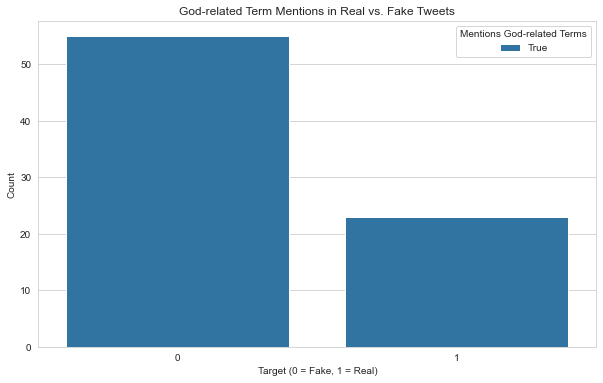

In [50]:
data_with_mention_of_god = df[df['mention_god_related']]


plt.figure(figsize=(10, 6))
sns.countplot(x='target', hue='mention_god_related', data=data_with_mention_of_god)
plt.xlabel('Target (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.title('God-related Term Mentions in Real vs. Fake Tweets')
plt.legend(title='Mentions God-related Terms')
plt.show()

# Visualizing Tokens

In [51]:
all_words = []
twitter_mask = np.array(Image.open('../img/twitter_mask2.jpg'))
for val in df.loc[df['target'] == 0, 'cleaned_tokens']:
     
    all_words.extend(val)

def sentence_maker(words):
    return " ".join(words)
    
all_words = sentence_maker(all_words)

wordcloud = WordCloud(width = 1400, height = 1400,
                background_color ='white',
                min_font_size = 10,
                mask = twitter_mask,
                collocations=True,
                max_words=150).generate(all_words)
plt.figure(figsize = (7, 7), facecolor = None)
plt.title('Top words for  Non-Disaster Tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wordcloud)
plt.axis("off")


ValueError: Only supported for TrueType fonts

In [52]:
all_words = []
for val in df.loc[df['target'] == 1, 'cleaned_tokens']:
     
    all_words.extend(val)

def sentence_maker(words):
    return " ".join(words)
    
all_words = sentence_maker(all_words)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                mask = twitter_mask,
                collocations=True,
                max_words=200).generate(all_words)
plt.figure(figsize = (7, 7), facecolor = None)
plt.title('Top words for Real Disaster tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wordcloud)
plt.axis("off")

ValueError: Only supported for TrueType fonts

Let's use now TfidfVectorizer to check the most important topics of respective tweets.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

Let's apply all necessary transformations to get top 5 topics of the tweets and their scores. We will focus on the most unique topics for each tweet.

In [54]:
df['clean_text_1'] = df['text'].apply(clean_text)

# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the clean_text column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text_1'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Function to get top n terms with highest TF-IDF scores for each document
def get_top_tfidf_terms(row, features, top_n=5):
    top_terms = row.sort_values(ascending=False).head(top_n)
    return [(term, row[term]) for term in top_terms.index]

# Get the feature names (terms)
features = tfidf_vectorizer.get_feature_names_out()

# Apply the function to each row in the TF-IDF DataFrame
top_tfidf_terms = tfidf_df.apply(lambda row: get_top_tfidf_terms(row, features), axis=1)

# Add the top TF-IDF terms to the original DataFrame
df['top_tfidf_terms'] = top_tfidf_terms

# Display the DataFrame with top TF-IDF terms
print(df[['text', 'top_tfidf_terms']].head())

                                                                                                                                    text  \
0                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                                                                 Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
3                                                                      13,000 people receive #wildfires evacuation orders in California    
4                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    

                                                                                                                                     top_tfidf_terms  
0       

Let's now count top 10 biggest ratios for the whole dataset.

In [ ]:
from collections import defaultdict
# Aggregate the top terms and their scores
term_scores = defaultdict(float)

for terms in top_tfidf_terms:
    for term, score in terms:
        term_scores[term] += score

# Convert the aggregated scores to a DataFrame
terms_df = pd.DataFrame(term_scores.items(), columns=['term', 'score'])

# Sort the DataFrame by score
terms_df = terms_df.sort_values(by='score', ascending=False)

# Display the top terms
print(terms_df.head(10))


          term      score
28          im  87.796729
76        like  80.291082
298       just  72.413882
135        amp  66.332820
35   emergency  53.720017
89         new  50.913306
573   disaster  48.648297
258       dont  46.358817
12      people  44.707142
724    burning  44.552732


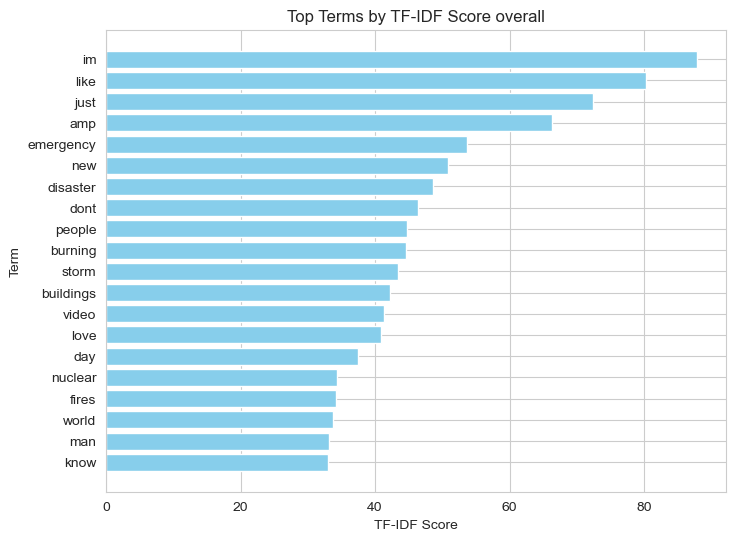

In [ ]:
# Plot the top 20 terms as a bar plot
top_n = 20
top_terms_df = terms_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_terms_df['term'], top_terms_df['score'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.title('Top Terms by TF-IDF Score overall')
plt.gca().invert_yaxis()
plt.show()

Let's divide it in terms of target and visualize them. Firstly let's focus on real tweets.

In [ ]:
from collections import defaultdict
# Aggregate the top terms and their scores
term_scores_real = defaultdict(float)

top_tfidf_terms_real=df[df['target']==1]['top_tfidf_terms']

for terms in top_tfidf_terms_real:
    for term, score in terms:
        term_scores_real[term] += score

# Convert the aggregated scores to a DataFrame
real_df = pd.DataFrame(term_scores_real.items(), columns=['term', 'score'])

# Sort the DataFrame by score
real_df = real_df.sort_values(by='score', ascending=False)

# Display the top terms
print(real_df.head(10))

           term      score
375    disaster  34.621943
509   buildings  31.798971
222       storm  30.682784
80        fires  27.455815
510     burning  26.310356
35    emergency  25.825504
1    earthquake  25.422429
283     bombing  25.229714
444   hiroshima  23.826038
13       police  23.272119


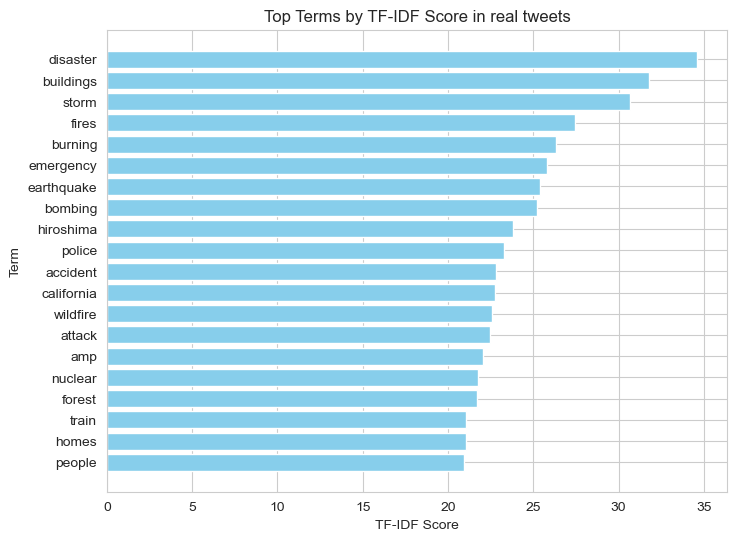

In [ ]:
import matplotlib.pyplot as plt

# Plot the top 20 terms as a bar plot
top_n = 20
top_terms_df = real_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_terms_df['term'], top_terms_df['score'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.title('Top Terms by TF-IDF Score in real tweets')
plt.gca().invert_yaxis()
plt.show()

Now let's focus on the fake ones.

In [ ]:
from collections import defaultdict
# Aggregate the top terms and their scores
term_scores_fake = defaultdict(float)

top_tfidf_terms_fake=df[df['target']==0]['top_tfidf_terms']

for terms in top_tfidf_terms_fake:
    for term, score in terms:
        term_scores_fake[term] += score

# Convert the aggregated scores to a DataFrame
fake_df = pd.DataFrame(term_scores_fake.items(), columns=['term', 'score'])

# Sort the DataFrame by score
fake_df = fake_df.sort_values(by='score', ascending=False)

# Display the top terms
print(fake_df.head(10))


          term      score
107         im  74.988511
25        like  61.735854
181       just  57.730348
71         amp  44.282073
38         new  40.775757
5         love  36.867483
321       dont  34.551655
253      video  28.726189
161  emergency  27.894513
176       body  27.618385


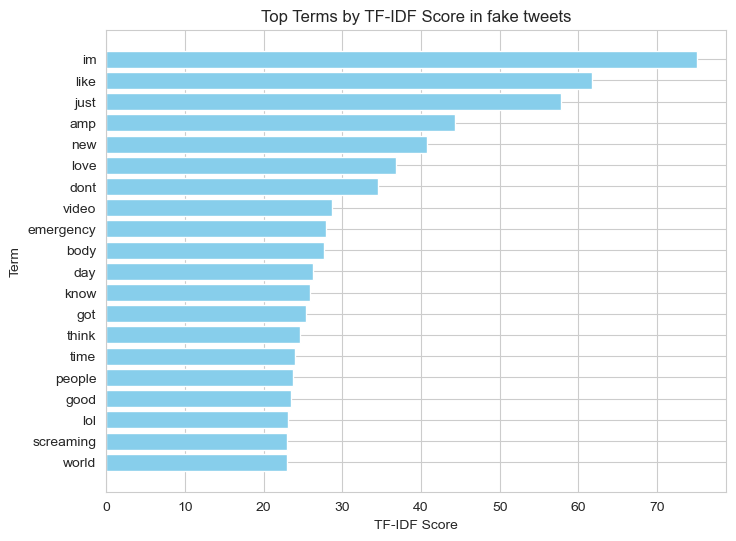

In [ ]:
import matplotlib.pyplot as plt

# Plot the top 20 terms as a bar plot
top_n = 20
top_terms_df = fake_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_terms_df['term'], top_terms_df['score'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.title('Top Terms by TF-IDF Score in fake tweets')
plt.gca().invert_yaxis()
plt.show()

Let's now focus on bigrams. Let's check, which of them are the most frequent in terms of their appearance in fake and real tweets

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['clean_text_1'])

# Sum up the counts of each bigram
bigram_counts = X.toarray().sum(axis=0)
bigram_features = vectorizer.get_feature_names_out()

# Create a DataFrame of bigrams and their counts
bigram_df = pd.DataFrame({'bigram': bigram_features, 'count': bigram_counts})

# Sort the DataFrame by count in descending order to get the most popular bigrams
bigram_df = bigram_df.sort_values(by='count', ascending=False)

# Display the top 10 most popular bigrams
print(bigram_df.head(10))


                    bigram  count
33842       suicide bomber     59
4639     burning buildings     59
20946          liked video     41
24654  northern california     41
25142            oil spill     39
7830            cross body     39
33844      suicide bombing     34
4946   california wildfire     34
21485           looks like     33
22343          mass murder     32


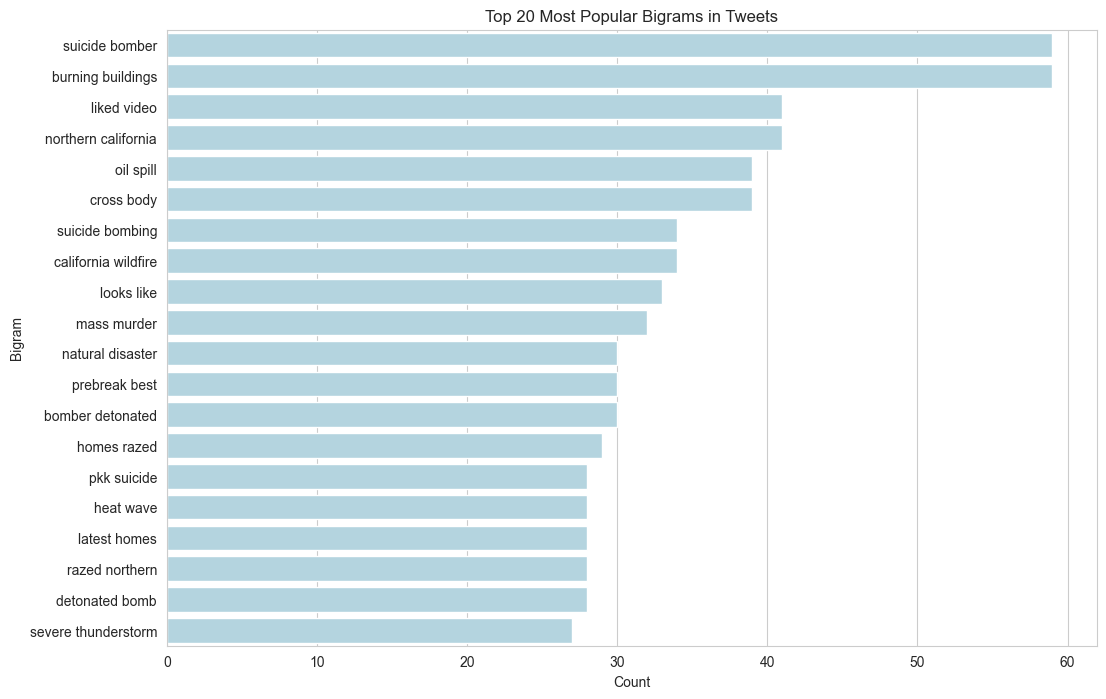

In [ ]:
# Plot the top 20 most popular bigrams
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=bigram_df.head(top_n),color='lightblue')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Top 20 Most Popular Bigrams in Tweets')
plt.show()

We will focus now on the fake tweets

In [ ]:
fake_tweets=df[df['target']==0]

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(fake_tweets['clean_text_1'])

# Sum up the counts of each bigram
bigram_counts = X.toarray().sum(axis=0)
bigram_features = vectorizer.get_feature_names_out()

# Create a DataFrame of bigrams and their counts
bigram_df = pd.DataFrame({'bigram': bigram_features, 'count': bigram_counts})

# Sort the DataFrame by count in descending order to get the most popular bigrams
bigram_df = bigram_df.sort_values(by='count', ascending=False)

# Display the top 10 most popular bigrams
print(bigram_df.head(10))

                  bigram  count
4571          cross body     38
12656        liked video     34
2290            body bag     26
2806   burning buildings     23
2292        body bagging     23
17299  reddit quarantine     21
13025         looks like     21
2293           body bags     20
4262      content policy     20
7499           feel like     20


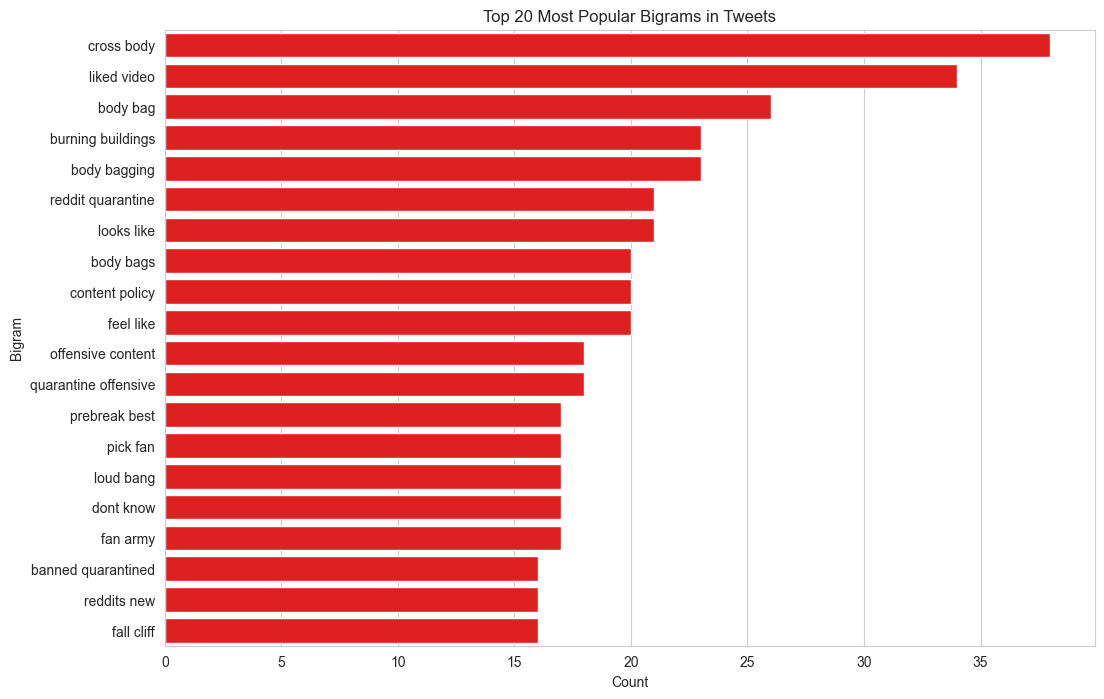

In [ ]:
# Plot the top 20 most popular bigrams
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=bigram_df.head(top_n),color='red')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Top 20 Most Popular Bigrams in Tweets')
plt.show()

We will do the same operations on the real ones

In [ ]:
fake_tweets=df[df['target']==1]

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(fake_tweets['clean_text_1'])

# Sum up the counts of each bigram
bigram_counts = X.toarray().sum(axis=0)
bigram_features = vectorizer.get_feature_names_out()

# Create a DataFrame of bigrams and their counts
bigram_df = pd.DataFrame({'bigram': bigram_features, 'count': bigram_counts})

# Sort the DataFrame by count in descending order to get the most popular bigrams
bigram_df = bigram_df.sort_values(by='count', ascending=False)

# Display the top 10 most popular bigrams
print(bigram_df.head(10))

                    bigram  count
14620       suicide bomber     59
10624  northern california     41
10860            oil spill     38
1995     burning buildings     36
14622      suicide bombing     34
2166   california wildfire     34
1631      bomber detonated     30
7292           homes razed     29
12261       razed northern     28
11537          pkk suicide     28


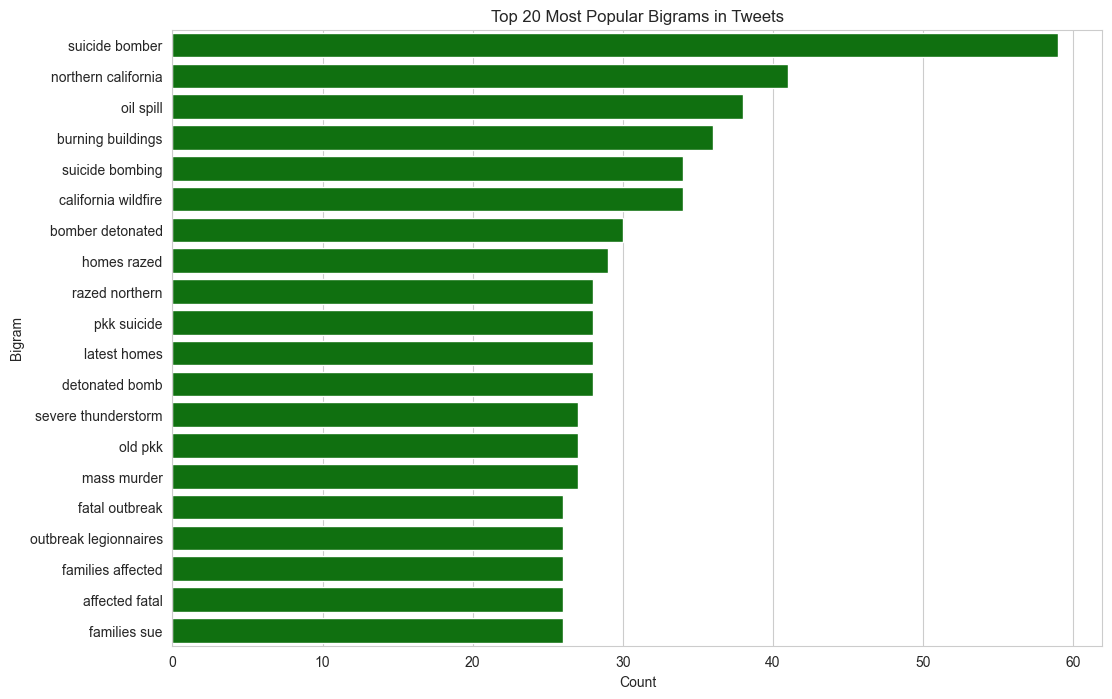

In [ ]:
# Plot the top 20 most popular bigrams
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=bigram_df.head(top_n),color='green')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Top 20 Most Popular Bigrams in Tweets')
plt.show()

# Vectorization

In [55]:
df['clean_text'] = df['cleaned_tokens'].apply(lambda x: ' '.join(x))
pd.DataFrame.to_csv(df,'train_data_after_EDA')
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

0                                                                             [deed, reason, earthquake, may, allah, forgive, us]
1                                                                                   [forest, fire, near, la, ronge, sask, canada]
2                                     [resident, ask, shelter, place, notify, officer, evacuation, shelter, place, order, expect]
3                                                                      [people, receive, wildfire, evacuation, order, california]
4                                                                 [get, send, photo, ruby, alaska, smoke, wildfire, pour, school]
                                                                  ...                                                            
7608                                                                    [two, giant, crane, hold, bridge, collapse, nearby, home]
7609                                                      [control, wild, fire, california

In [ ]:
clf = MultinomialNB()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.7951411687458962
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       874
           1       0.78      0.73      0.75       649

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.80      0.79      1523



In [ ]:
# Calculate feature importance
feature_names = vectorizer.get_feature_names_out()
feature_log_prob = clf.feature_log_prob_

# Feature importance for each class
# Here we use the absolute value of log probabilities for simplicity
feature_importance = np.abs(feature_log_prob)

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame(feature_importance.T, index=feature_names, columns=clf.classes_)

# Display the top features for each class
print("Top features for True class:")
print(importance_df[1].sort_values(ascending=False).head(10))

print("Top features for False class:")
print(importance_df[0].sort_values(ascending=False).head(10))

Top features for True class:
__                10.501857
minus             10.501857
missile           10.501857
mislead           10.501857
misha             10.501857
misguided         10.501857
misfortunebut     10.501857
misfit            10.501857
miscalculation    10.501857
mirror            10.501857
Name: 1, dtype: float64
Top features for False class:
encourage          10.6284
ol                 10.6284
shanghai           10.6284
elvia              10.6284
shanghaiûªs        10.6284
kasabwe            10.6284
kashmir            10.6284
kashmirconflict    10.6284
olap               10.6284
shaper             10.6284
Name: 0, dtype: float64


In [ ]:
# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1, 5, 10],
    'fit_prior': [True, False]
}

# Initialize the MultinomialNB classifier
clf = MultinomialNB()

# Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Perform grid search and fit to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the best model with the entire training data
best_clf = grid_search.best_estimator_

# Make predictions
y_pred = best_clf.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Best Parameters: {'alpha': 5, 'fit_prior': True}
Accuracy: 0.7951411687458962
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       874
           1       0.79      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.80      0.79      1523



In [ ]:
df=pd.read_csv('../data/train.csv')


In [ ]:
processing_pipeline = Pipeline([
    
    ('text_feature_extractor', TextFeatureExtractor()),
    ('text_processing', TextProcessing())
])

processing_pipeline.fit_transform(df)
joblib.dump(processing_pipeline, '../pipelines/text_pipeline.joblib')

['../pipelines/text_pipeline.joblib']

In [ ]:
df

,id,keyword,location,text,target,count_caps_lock,count_exclamation_mark,count_hashtags,count_words,count_punctuation,count_links,count_stopwords,count_mentions,polarity,subjectivity,emotion,processed_text,processed_text_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,1,0,1,13,1,0,5,0,0.000000,0.000000,"[fear, anger, surprise, negative, sadness]","[deed, reason, earthquake, may, allah, forgive, us]",deed reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,7,1,0,0,0,0.100000,0.400000,[fear],"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,0,0,0,22,3,0,9,0,-0.018750,0.387500,"[trust, positive, negative, anticipation]","[resident, ask, shelter, place, notify, officer, evacuation, shelter, place, order, expect]",resident ask shelter place notify officer evacuation shelter place order expect
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,0,0,1,8,2,0,1,0,0.000000,0.000000,[negative],"[people, receive, wildfire, evacuation, order, california]",people receive wildfire evacuation order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,0,0,2,16,2,0,6,0,0.000000,0.000000,[trust],"[get, send, photo, ruby, alaska, smoke, wildfire, pour, school]",get send photo ruby alaska smoke wildfire pour school
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,0,0,0,11,5,1,2,0,0.000000,1.000000,[fear],"[two, giant, crane, hold, bridge, collapse, nearby, home]",two giant crane hold bridge collapse nearby home
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,0,0,0,20,4,0,7,2,0.150000,0.350000,"[surprise, negative]","[control, wild, fire, california, even, northern, part, state, trouble]",control wild fire california even northern part state trouble
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,2,0,0,8,11,1,1,0,0.000000,0.000000,"[fear, anger, anticip, trust, surprise, positive, negative, sadness, disgust, joy]","[volcano, hawaii]",volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,0,0,0,19,5,0,5,0,-0.260417,0.583333,"[fear, anger, positive, negative, disgust]","[police, investigate, ebike, collide, car, little, portugal, ebike, rider, suffer, serious, nonlife, threatening, injury]",police investigate ebike collide car little portugal ebike rider suffer serious nonlife threatening injury
